In [3]:
# Install Taichi and required dependencies
!pip install taichi matplotlib numpy pillow
!pip install git+https://github.com/Worter623/TaiCrowd.git

import taichi as ti
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
import math

# Initialize Taichi (use CPU for Colab compatibility)
ti.init(arch=ti.cpu)  # Use ti.gpu if CUDA is available


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 MB 18.5 MB/s eta 0:00:00
  Cloning https://github.com/Worter623/TaiCrowd.git to /tmp/pip-req-build-pg6ssvz4
  Running command git clone --filter=blob:none --quiet https://github.com/Worter623/TaiCrowd.git /tmp/pip-req-build-pg6ssvz4
  Resolved https://github.com/Worter623/TaiCrowd.git to commit 8882426b6ffa174ec497ee3312e2752449e015cf
ERROR: git+https://github.com/Worter623/TaiCrowd.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
[Taichi] version 1.7.3, llvm 15.0.4, commit 5ec301be, linux, python 3.11.13
[Taichi] Starting on arch=x64


In [4]:
@ti.data_oriented
class BehavioralHeuristicsModel:
    def __init__(self, max_agents=1000, scenario_width=10.0, scenario_height=10.0):
        # Vadere BHM Parameters (same as before)
        self.step_length_intercept = 0.4625
        self.step_length_slope_speed = 0.2345
        self.step_length_sd = 0.0036
        self.tangential_evasion = True
        self.sideways_evasion = True
        self.follower_proximity_navigation = True
        self.evasion_detour_threshold = 0.1
        self.follower_distance = 10.0
        self.distance_to_keep = 0.5
        self.follower_angle_movement = 1.5707963267948966
        self.follower_angle_position = 1.5707963267948966

        # Agent properties
        self.max_agents = max_agents
        self.scenario_width = scenario_width
        self.scenario_height = scenario_height

        # Taichi fields
        self.positions = ti.Vector.field(2, dtype=ti.f32, shape=max_agents)
        self.velocities = ti.Vector.field(2, dtype=ti.f32, shape=max_agents)
        self.targets = ti.Vector.field(2, dtype=ti.f32, shape=max_agents)
        self.radii = ti.field(dtype=ti.f32, shape=max_agents)
        self.preferred_speeds = ti.field(dtype=ti.f32, shape=max_agents)
        self.active = ti.field(dtype=ti.i32, shape=max_agents)
        self.current_heuristic = ti.field(dtype=ti.i32, shape=max_agents)

        # Obstacles
        self.obstacles = ti.Vector.field(2, dtype=ti.f32, shape=100)
        self.obstacle_radii = ti.field(dtype=ti.f32, shape=100)
        self.num_obstacles = ti.field(dtype=ti.i32, shape=())

        # Heuristic types
        self.STEP_OR_WAIT = 0
        self.TANGENTIAL_EVASION = 1
        self.SIDEWAYS_EVASION = 2
        self.FOLLOWER = 3

    @ti.func
    def calculate_step_length(self, preferred_speed: ti.f32) -> ti.f32:
        """Calculate step length based on Vadere BHM parameters"""
        return self.step_length_intercept + self.step_length_slope_speed * preferred_speed

    @ti.func
    def distance(self, p1: ti.types.vector(2, ti.f32), p2: ti.types.vector(2, ti.f32)) -> ti.f32:
        """Calculate Euclidean distance between two points"""
        return (p1 - p2).norm()

    @ti.func
    def normalize_safe(self, v: ti.types.vector(2, ti.f32)) -> ti.types.vector(2, ti.f32):
        """Safely normalize a vector - FIXED to avoid return in if block"""
        norm = v.norm()
        result = ti.Vector([0.0, 0.0])

        # Use conditional assignment instead of return in if block
        if norm > 1e-6:
            result = v / norm
        # If norm <= 1e-6, result remains [0.0, 0.0]

        return result

    @ti.func
    def check_collision(self, pos: ti.types.vector(2, ti.f32), next_pos: ti.types.vector(2, ti.f32),
                       agent_id: ti.i32) -> ti.i32:
        """Check if moving from pos to next_pos would cause collision - FIXED"""
        collision = 0
        agent_radius = self.radii[agent_id]

        # Check collision with other agents
        for other_id in range(self.max_agents):
            # Only check if no collision found yet and valid other agent
            if collision == 0 and other_id != agent_id and self.active[other_id]:
                other_pos = self.positions[other_id]
                other_radius = self.radii[other_id]
                min_distance = agent_radius + other_radius + self.distance_to_keep

                if self.distance(next_pos, other_pos) < min_distance:
                    collision = 1

        # Check collision with obstacles only if no agent collision found
        for obs_id in range(self.num_obstacles[None]):
            if collision == 0:  # Only check if no collision found yet
                obs_pos = self.obstacles[obs_id]
                obs_radius = self.obstacle_radii[obs_id]
                min_distance = agent_radius + obs_radius

                if self.distance(next_pos, obs_pos) < min_distance:
                    collision = 1

        return collision

    @ti.func
    def step_or_wait_heuristic(self, agent_id: ti.i32) -> ti.types.vector(2, ti.f32):
        """Implement step or wait heuristic - FIXED"""
        pos = self.positions[agent_id]
        target = self.targets[agent_id]
        step_length = self.calculate_step_length(self.preferred_speeds[agent_id])

        # Direction towards target
        direction = self.normalize_safe(target - pos)
        next_pos = pos + direction * step_length
        result = pos  # Default to staying in place

        # Check for collision and assign result
        if self.check_collision(pos, next_pos, agent_id) == 0:
            result = next_pos

        return result

    @ti.func
    def tangential_evasion_heuristic(self, agent_id: ti.i32) -> ti.types.vector(2, ti.f32):
        """Implement tangential evasion heuristic - FIXED"""
        pos = self.positions[agent_id]
        target = self.targets[agent_id]
        step_length = self.calculate_step_length(self.preferred_speeds[agent_id])

        # First try direct step
        direction = self.normalize_safe(target - pos)
        next_pos = pos + direction * step_length
        result = pos  # Default to staying

        if self.check_collision(pos, next_pos, agent_id) == 0:
            result = next_pos
        else:
            # Find closest conflicting agent
            closest_agent = -1
            min_distance = 1000.0  # Use large value instead of float('inf')

            for other_id in range(self.max_agents):
                if other_id != agent_id and self.active[other_id]:
                    dist = self.distance(pos, self.positions[other_id])
                    if dist < min_distance:
                        min_distance = dist
                        closest_agent = other_id

            if closest_agent >= 0:
                # Calculate tangential evasion points
                obstacle_pos = self.positions[closest_agent]
                obstacle_radius = self.radii[closest_agent] + self.radii[agent_id] + self.distance_to_keep

                # Vector from obstacle to agent
                to_agent = pos - obstacle_pos
                to_agent_normalized = self.normalize_safe(to_agent)

                # Perpendicular vectors for tangential evasion
                perp1 = ti.Vector([-to_agent_normalized.y, to_agent_normalized.x])
                perp2 = ti.Vector([to_agent_normalized.y, -to_agent_normalized.x])

                # Tangent points on the obstacle circle
                tangent1 = obstacle_pos + to_agent_normalized * obstacle_radius + perp1 * step_length
                tangent2 = obstacle_pos + to_agent_normalized * obstacle_radius + perp2 * step_length

                # Choose the tangent point that gets closer to target
                dist1 = self.distance(tangent1, target)
                dist2 = self.distance(tangent2, target)

                evasion_pos = tangent1
                if dist2 < dist1:
                    evasion_pos = tangent2

                if self.check_collision(pos, evasion_pos, agent_id) == 0:
                    result = evasion_pos
                else:
                    # Try the other tangent point
                    other_pos = tangent2
                    if dist2 < dist1:
                        other_pos = tangent1
                    if self.check_collision(pos, other_pos, agent_id) == 0:
                        result = other_pos

        return result

    @ti.func
    def sideways_evasion_heuristic(self, agent_id: ti.i32) -> ti.types.vector(2, ti.f32):
        """Implement sideways evasion heuristic - FIXED"""
        # First try tangential evasion
        result = self.tangential_evasion_heuristic(agent_id)
        pos = self.positions[agent_id]

        # Check if we actually moved (distance > small threshold)
        if (result - pos).norm() <= 0.01:  # If we didn't move much
            target = self.targets[agent_id]
            step_length = self.calculate_step_length(self.preferred_speeds[agent_id])

            # Direction towards target
            to_target = self.normalize_safe(target - pos)

            # Perpendicular directions (sideways)
            left = ti.Vector([-to_target.y, to_target.x])
            right = ti.Vector([to_target.y, -to_target.x])

            # Try left step
            left_pos = pos + left * step_length
            if self.check_collision(pos, left_pos, agent_id) == 0:
                result = left_pos
            else:
                # Try right step
                right_pos = pos + right * step_length
                if self.check_collision(pos, right_pos, agent_id) == 0:
                    result = right_pos

        return result

    @ti.func
    def follower_heuristic(self, agent_id: ti.i32) -> ti.types.vector(2, ti.f32):
        """Implement follower heuristic - FIXED"""
        pos = self.positions[agent_id]
        target = self.targets[agent_id]

        # Check if there's a collision ahead
        step_length = self.calculate_step_length(self.preferred_speeds[agent_id])
        direction = self.normalize_safe(target - pos)

        # Look ahead multiple steps
        collision_ahead = 0
        for step in range(5):  # plannedStepsAhead
            check_pos = pos + direction * step_length * (step + 1)
            if self.check_collision(pos, check_pos, agent_id) == 1:
                collision_ahead = 1
                break

        result = pos  # Default to staying

        if collision_ahead == 1:
            # Find someone to follow
            best_follower = -1
            min_distance = 1000.0  # Use large value instead of float('inf')

            for other_id in range(self.max_agents):
                if other_id != agent_id and self.active[other_id]:
                    other_pos = self.positions[other_id]
                    other_vel = self.velocities[other_id]

                    # Check if within following distance
                    dist = self.distance(pos, other_pos)
                    if dist < self.follower_distance and dist < min_distance:
                        # Check if moving in similar direction
                        my_direction = self.normalize_safe(target - pos)
                        other_direction = self.normalize_safe(other_vel)

                        dot_product = my_direction.dot(other_direction)
                        if dot_product > ti.cos(self.follower_angle_movement):
                            min_distance = dist
                            best_follower = other_id

            if best_follower >= 0:
                # Follow the selected agent
                follow_target = self.positions[best_follower]
                follow_direction = self.normalize_safe(follow_target - pos)
                result = pos + follow_direction * step_length
            else:
                # Fall back to sideways evasion
                result = self.sideways_evasion_heuristic(agent_id)
        else:
            # No collision ahead, proceed normally
            result = self.sideways_evasion_heuristic(agent_id)

        return result

    @ti.kernel
    def update(self, dt: ti.f32):
        """Update all agents using their respective heuristics - FIXED"""
        for agent_id in range(self.max_agents):
            if self.active[agent_id]:
                heuristic = self.current_heuristic[agent_id]
                new_pos = self.positions[agent_id]  # Default to current position

                # Use conditional assignment instead of if-else with returns
                if heuristic == self.STEP_OR_WAIT:
                    new_pos = self.step_or_wait_heuristic(agent_id)
                elif heuristic == self.TANGENTIAL_EVASION:
                    new_pos = self.tangential_evasion_heuristic(agent_id)
                elif heuristic == self.SIDEWAYS_EVASION:
                    new_pos = self.sideways_evasion_heuristic(agent_id)
                elif heuristic == self.FOLLOWER:
                    new_pos = self.follower_heuristic(agent_id)

                # Update velocity and position
                old_pos = self.positions[agent_id]
                self.velocities[agent_id] = (new_pos - old_pos) / dt
                self.positions[agent_id] = new_pos

                # Check if agent reached target
                #if self.distance(new_pos, self.targets[agent_id]) < 0.01:
                    #self.active[agent_id] = 0

    # Keep all your existing helper methods (add_agent, add_obstacle, etc.) unchanged
    def add_agent(self, position: tuple, target: tuple, radius: float = 0.25,
                  preferred_speed: float = 1.34, heuristic: int = None) -> int:
        """Add a new agent to the simulation"""
        for i in range(self.max_agents):
            if not self.active[i]:
                self.positions[i] = ti.Vector([position[0], position[1]])
                self.targets[i] = ti.Vector([target[0], target[1]])
                self.radii[i] = radius
                self.preferred_speeds[i] = preferred_speed
                self.active[i] = 1

                if heuristic is None:
                    self.current_heuristic[i] = self.TANGENTIAL_EVASION
                else:
                    self.current_heuristic[i] = heuristic

                return i
        return -1

    def add_obstacle(self, position: tuple, radius: float = 0.5):
        """Add an obstacle to the simulation"""
        obs_id = self.num_obstacles[None]
        if obs_id < 100:
            self.obstacles[obs_id] = ti.Vector([position[0], position[1]])
            self.obstacle_radii[obs_id] = radius
            self.num_obstacles[None] += 1

    def get_positions(self) -> list:
        """Get current positions of all active agents"""
        positions = []
        for i in range(self.max_agents):
            if self.active[i]:
                pos = self.positions[i]
                positions.append((pos.x, pos.y))
        return positions

    def get_agent_data(self) -> dict:
        """Get comprehensive agent data for analysis"""
        data = {
            'positions': [],
            'targets': [],
            'velocities': [],
            'heuristics': [],
            'active': []
        }

        for i in range(self.max_agents):
            if self.active[i]:
                pos = self.positions[i]
                target = self.targets[i]
                vel = self.velocities[i]

                data['positions'].append((pos.x, pos.y))
                data['targets'].append((target.x, target.y))
                data['velocities'].append((vel.x, vel.y))
                data['heuristics'].append(self.current_heuristic[i])
                data['active'].append(self.active[i])

        return data


Creating crossing scenario...
Initial state:


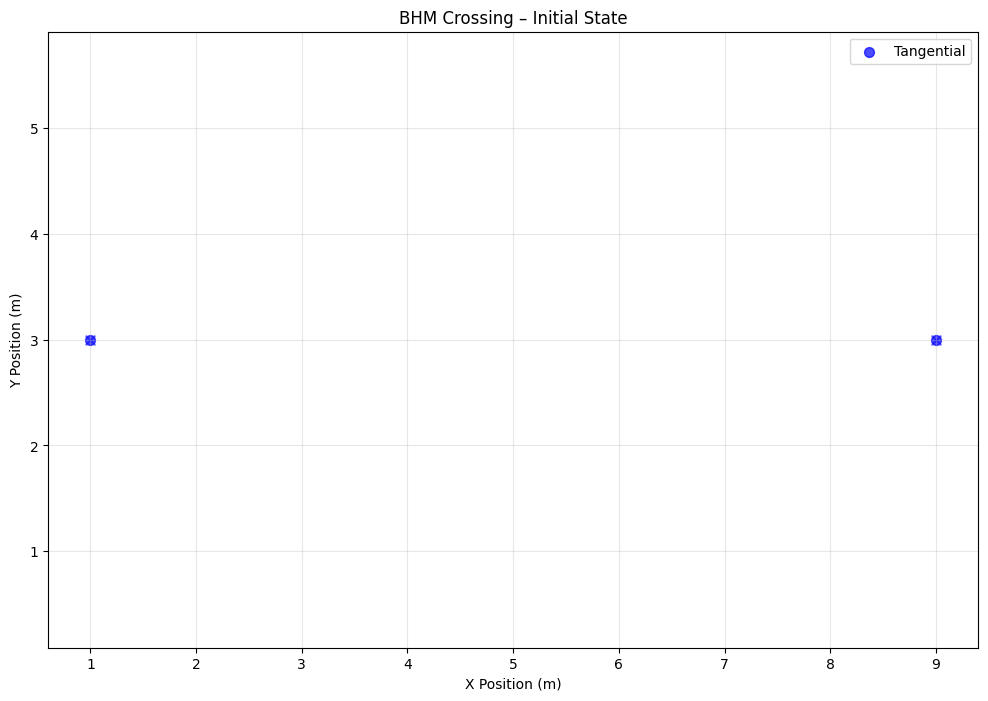

Step 0


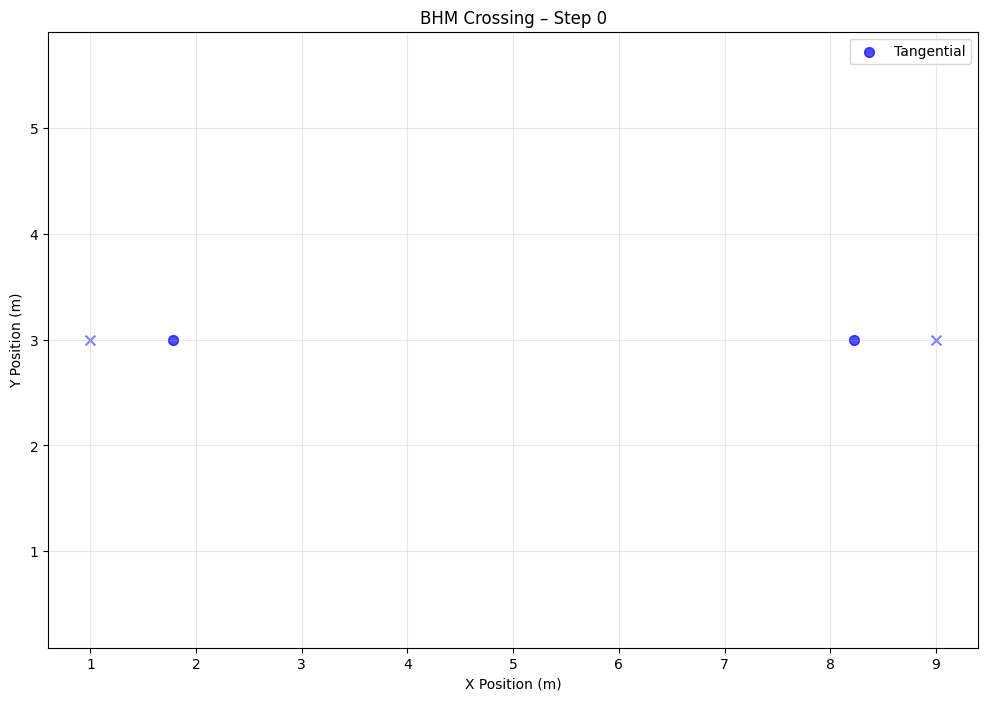

Step 1


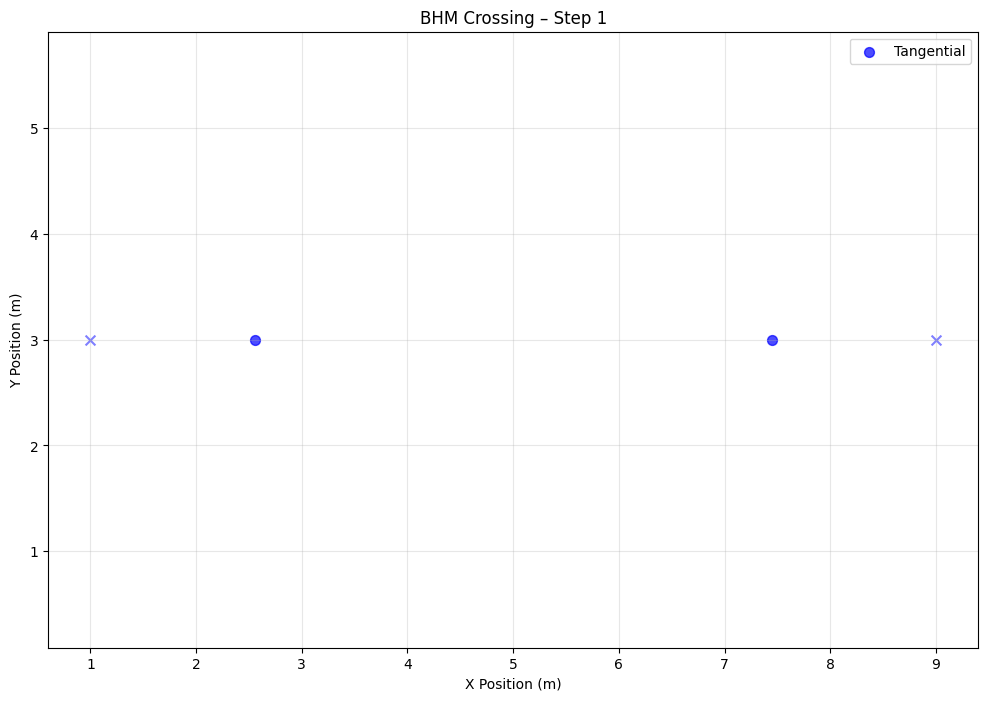

Step 2


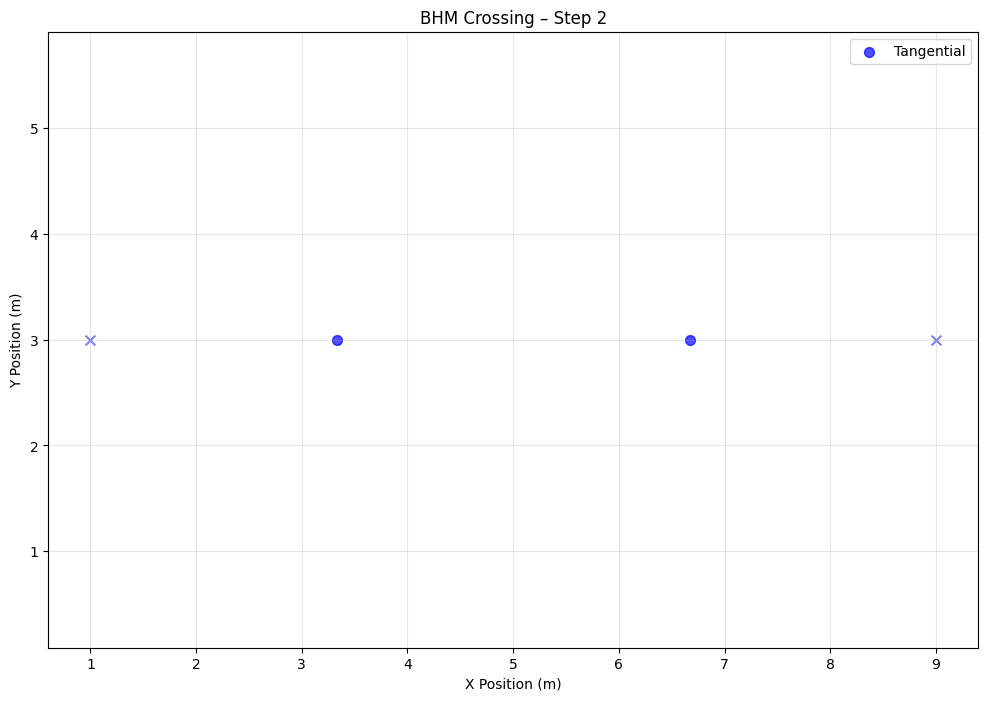

Step 3


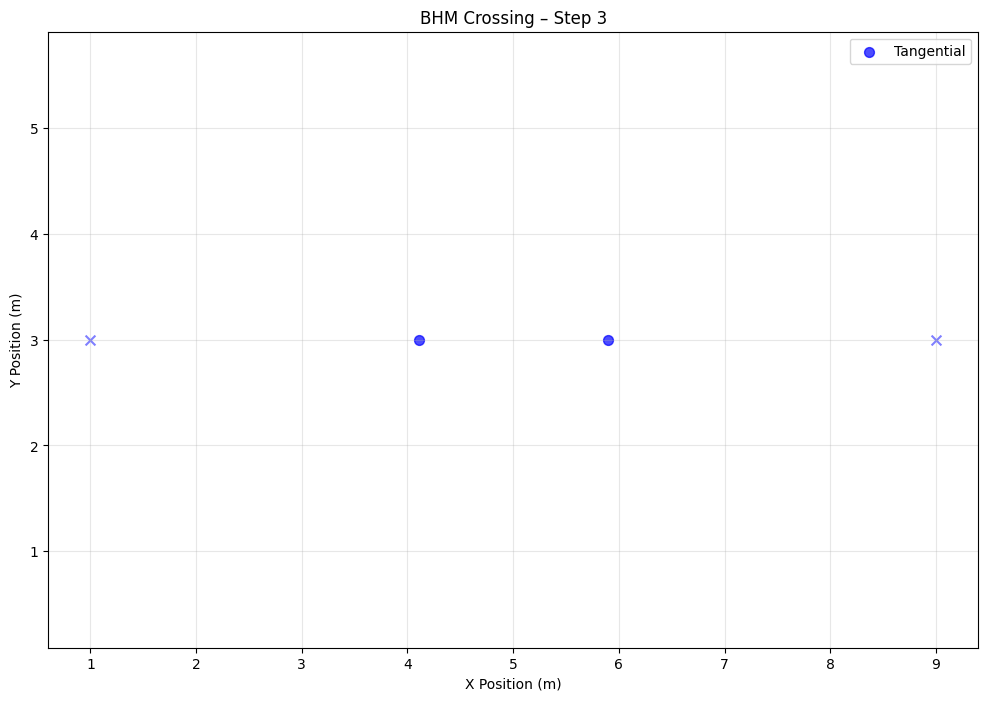

Step 4


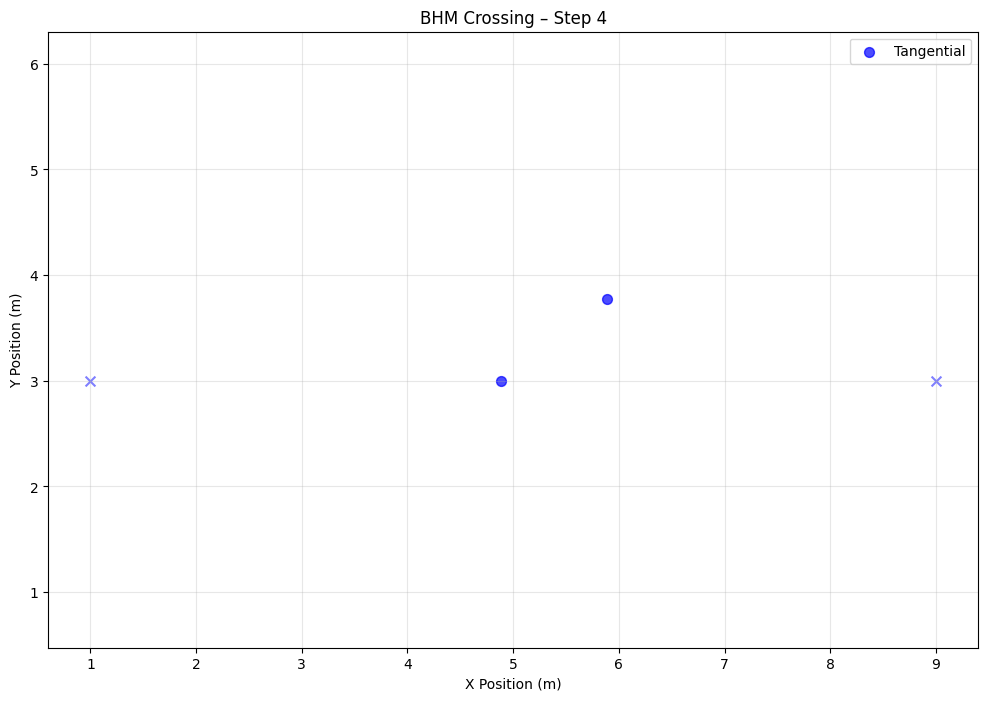

Step 5


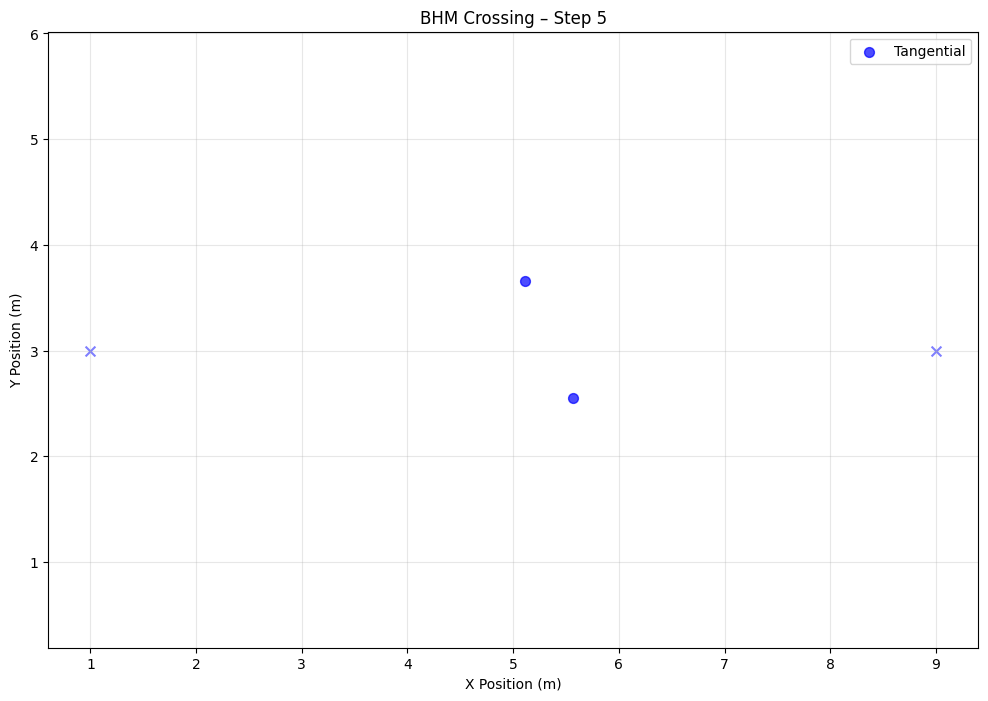

Step 6


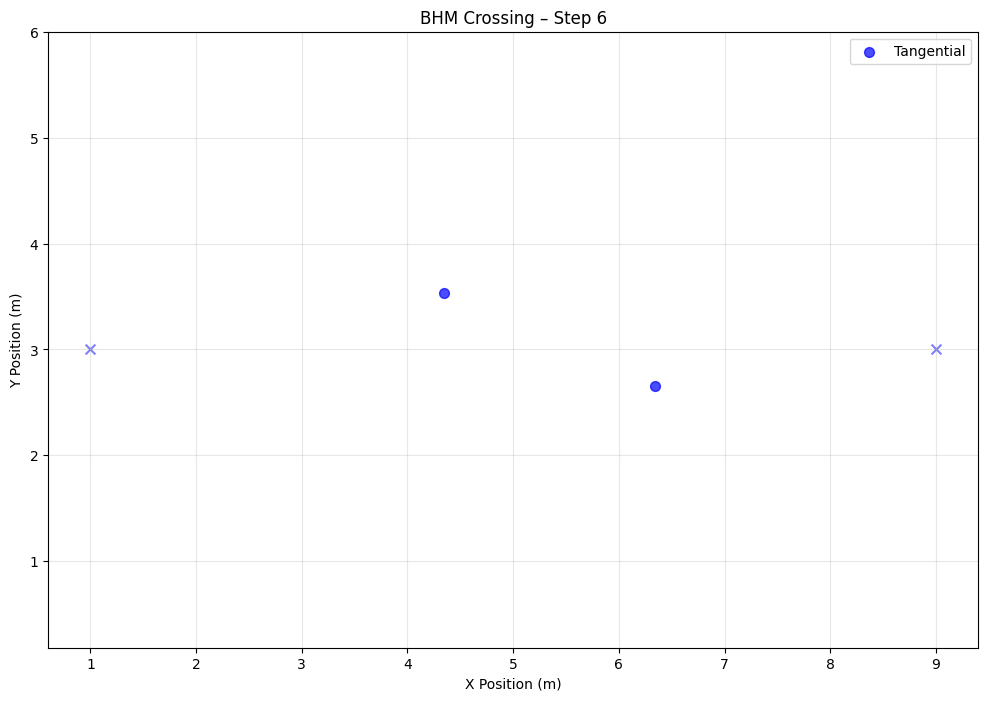

Step 7


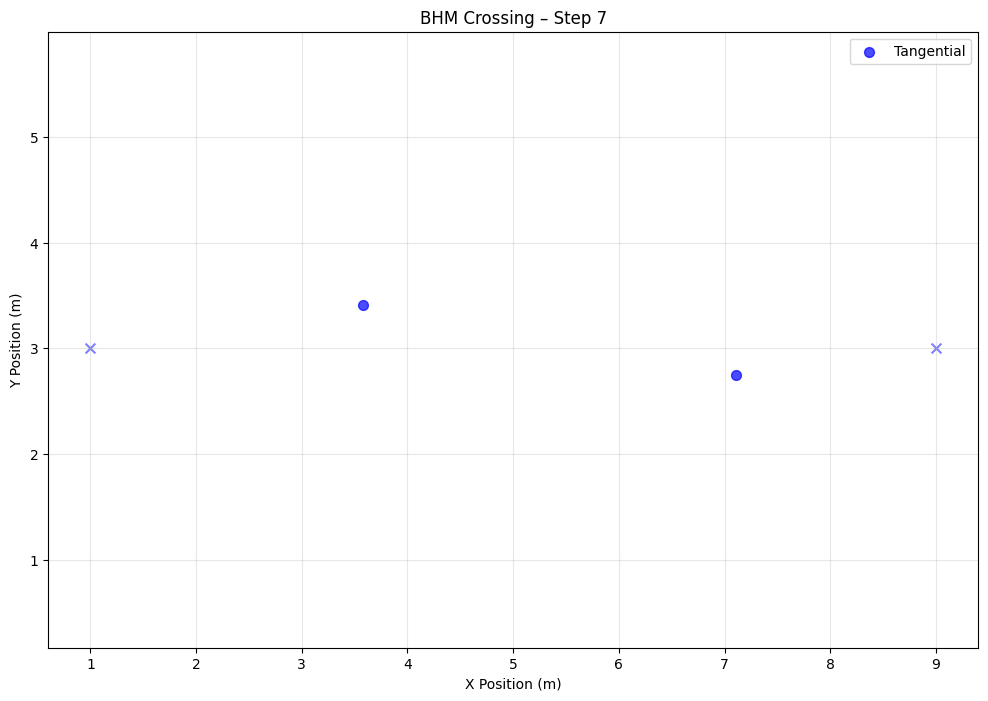

Step 8


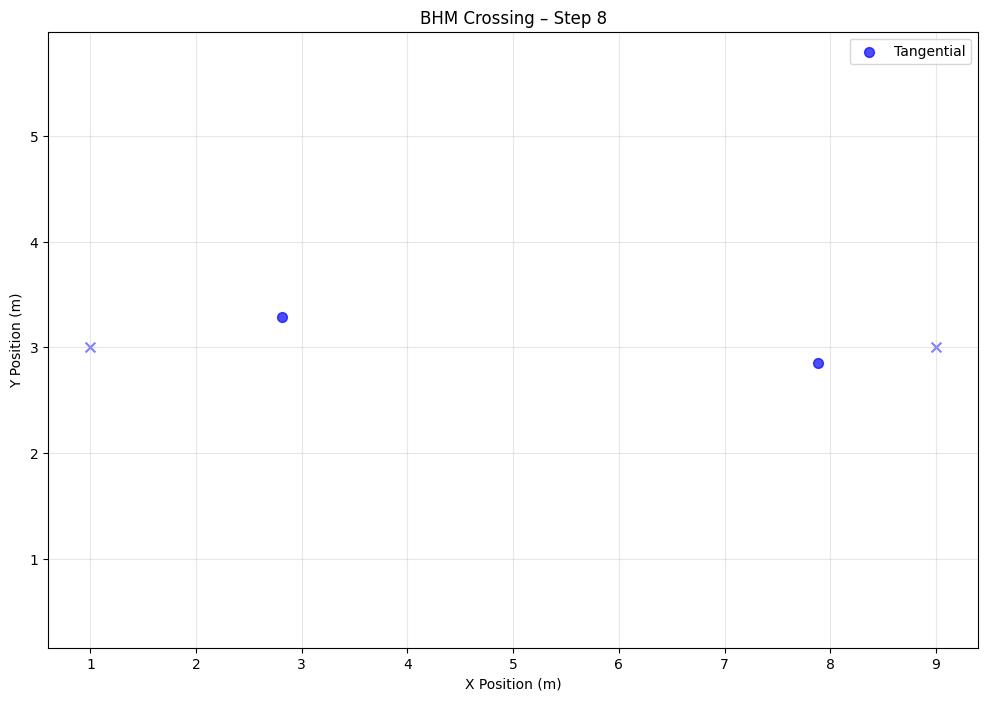

Step 9


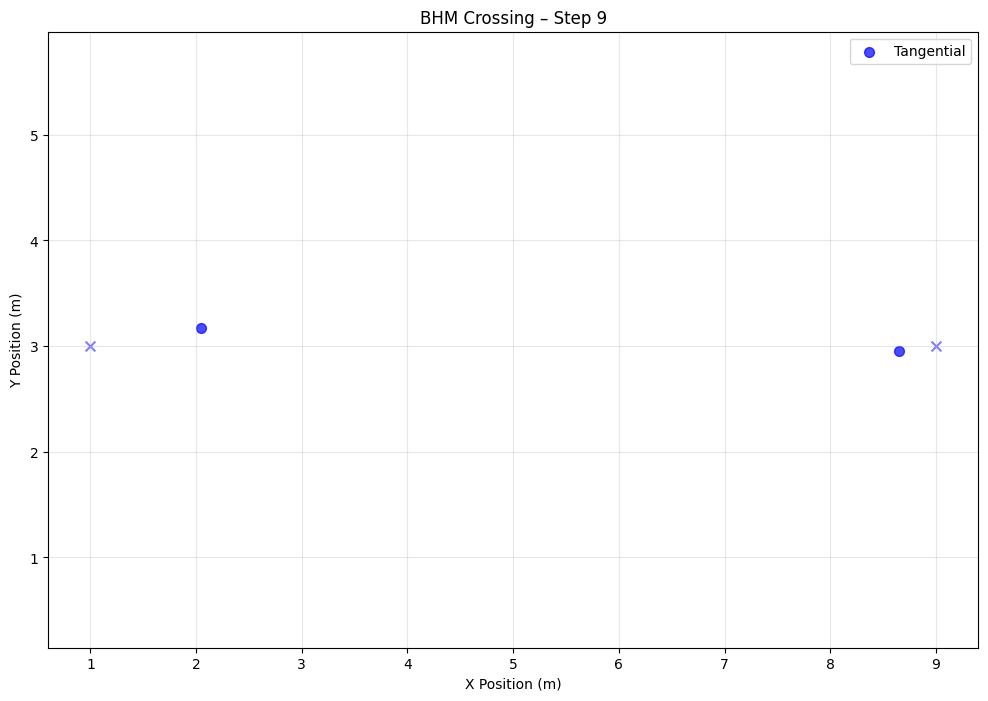

Simulation complete!


In [7]:

# (Assume BehavioralHeuristicsModel class as defined previously is already imported here)

def create_bottleneck_scenario() -> BehavioralHeuristicsModel:
    """
    Create a simple crossing scenario where two pedestrians start
    on opposite sides and walk to each other's starting position.
    """
    model = BehavioralHeuristicsModel(max_agents=2, scenario_width=10.0, scenario_height=6.0)

    # No obstacles for the crossing scenario

    # Pedestrian 1: start left → go right
    start1 = (1.0, 3.0)
    target1 = (9.0, 3.0)
    model.add_agent(start1, target1, heuristic=model.TANGENTIAL_EVASION)

    # Pedestrian 2: start right → go left
    start2 = (9.0, 3.0)
    target2 = (1.0, 3.0)
    model.add_agent(start2, target2, heuristic=model.TANGENTIAL_EVASION)

    return model

def create_corridor_scenario() -> BehavioralHeuristicsModel:
    """Create a bidirectional corridor scenario (unchanged)."""
    model = BehavioralHeuristicsModel(max_agents=200, scenario_width=50.0, scenario_height=8.0)
    # Corridor walls
    for x in range(50):
        model.add_obstacle((x, 0.5), 0.3)
        model.add_obstacle((x, 7.5), 0.3)
    # Agents in both directions
    for i in range(100):
        y = random.uniform(2.0, 6.0)
        model.add_agent((random.uniform(1.0, 3.0), y), (47.0, y), heuristic=model.FOLLOWER)
        model.add_agent((random.uniform(47.0, 49.0), y), (3.0, y), heuristic=model.FOLLOWER)
    return model

def visualize_simulation(model: BehavioralHeuristicsModel, title: str = "BHM Simulation"):
    """Visualize the current state of the simulation (unchanged)."""
    plt.figure(figsize=(12, 8))
    data = model.get_agent_data()
    if data['positions']:
        positions = np.array(data['positions'])
        targets   = np.array(data['targets'])
        heuristics = np.array(data['heuristics'])
        colors = ['red', 'blue', 'green', 'orange']
        names  = ['Step/Wait', 'Tangential', 'Sideways', 'Follower']
        for h in range(4):
            mask = heuristics == h
            if np.any(mask):
                plt.scatter(positions[mask,0], positions[mask,1],
                            c=colors[h], label=names[h], alpha=0.7, s=50)
                plt.scatter(targets[mask,0],   targets[mask,1],
                            c=colors[h], marker='x', alpha=0.5, s=50)
    # Obstacles
    for i in range(model.num_obstacles[None]):
        pos = model.obstacles[i]
        r   = model.obstacle_radii[i]
        circle = plt.Circle((pos.x, pos.y), r, color='black', alpha=0.8)
        plt.gca().add_patch(circle)
    plt.xlim(0, model.scenario_width)
    plt.ylim(0, model.scenario_height)
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.axis('equal')
    plt.show()

def run_simulation_example():
    """Run the crossing scenario example."""
    print("Creating crossing scenario...")
    model = create_bottleneck_scenario()

    print("Initial state:")
    visualize_simulation(model, "BHM Crossing – Initial State")

    dt = 0.1
    steps = 10
    for step in range(steps):
        model.update(dt)
        if step % 1 == 0:
            print(f"Step {step}")
            visualize_simulation(model, f"BHM Crossing – Step {step}")

    print("Simulation complete!")

# Execute the example
if __name__ == "__main__":
    run_simulation_example()


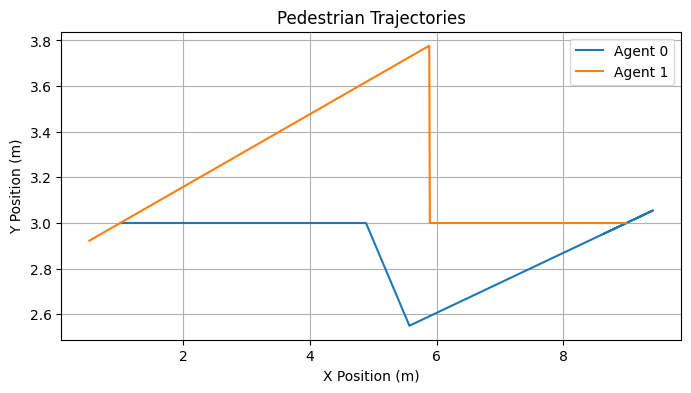

Trajectories saved to trajectories.csv


In [8]:
# Code cell: Run simulation and export trajectories to CSV

import csv
import numpy as np
import matplotlib.pyplot as plt

# Assuming BehavioralHeuristicsModel is already defined and imported
# and create_bottleneck_scenario() (crossing scenario) exists.

# 1. Create the model
model = create_bottleneck_scenario()

# 2. Prepare CSV file
csv_filename = 'trajectories.csv'
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Header: time, agent_id, x, y
    writer.writerow(['time', 'agent_id', 'x', 'y'])

# 3. Run simulation, record positions each step
dt = 0.1
steps = 200
for step in range(steps + 1):
    t = step * dt
    data = model.get_agent_data()
    # Write each agent's current position
    for agent_id, pos in enumerate(data['positions']):
        x, y = pos
        with open(csv_filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([t, agent_id, x, y])
    # Advance simulation
    if step < steps:
        model.update(dt)

# 4. Load and plot trajectories from CSV
times = {}
xs = {}
ys = {}

with open(csv_filename, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        aid = int(row['agent_id'])
        t = float(row['time'])
        x = float(row['x'])
        y = float(row['y'])
        times.setdefault(aid, []).append(t)
        xs.setdefault(aid, []).append(x)
        ys.setdefault(aid, []).append(y)

plt.figure(figsize=(8, 4))
for aid in times:
    plt.plot(xs[aid], ys[aid], label=f'Agent {aid}')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Pedestrian Trajectories')
plt.legend()
plt.grid(True)
plt.show()

print(f"Trajectories saved to {csv_filename}")


In [11]:
import numpy as np
import csv

def run_head_on_experiment(exp_id):
    """Run a single head-on experiment and return data in required format"""
    model = BehavioralHeuristicsModel(max_agents=2, scenario_width=10.0, scenario_height=6.0)

    # Define areas for agent starting positions
    left_area = (0.5, 2.5, 1.0, 1.0)  # (x, y, width, height)
    right_area = (8.5, 2.5, 1.0, 1.0)

    # Generate random starting positions
    start1_x = np.random.uniform(left_area[0], left_area[0] + left_area[2])
    start1_y = np.random.uniform(left_area[1], left_area[1] + left_area[3])
    start2_x = np.random.uniform(right_area[0], right_area[0] + right_area[2])
    start2_y = np.random.uniform(right_area[1], right_area[1] + right_area[3])

    # Define targets (each pedestrian goes to other's start area)
    target1 = (9.0, 3.0)
    target2 = (1.0, 3.0)

    # Generate random speeds within typical range
    ped1_speed = np.random.uniform(0.5, 2.2)
    ped2_speed = np.random.uniform(0.5, 2.2)

    # Add agents to model
    model.add_agent((start1_x, start1_y), target1, preferred_speed=ped1_speed)
    model.add_agent((start2_x, start2_y), target2, preferred_speed=ped2_speed)

    # Run simulation
    dt = 0.1
    max_steps = 200
    for step in range(max_steps):
        model.update(dt)
        data = model.get_agent_data()
        # Stop if both reached targets
        if not any(data['active']):
            break

    # Get final positions
    final_positions = data['positions']

    return [
        start1_x, start1_y, final_positions[0][0], final_positions[0][1], ped1_speed,
        start2_x, start2_y, final_positions[1][0], final_positions[1][1], ped2_speed,
        exp_id
    ]

def generate_head_on_dataset(num_experiments=21, output_file="head_on_results.csv"):
    """Generate dataset of head-on experiments"""
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for exp_id in range(1, num_experiments + 1):
            experiment_data = run_head_on_experiment(exp_id)
            writer.writerow(experiment_data)
            print(f"Completed experiment {exp_id}")

# Generate 21 experiments to match your data
generate_head_on_dataset(num_experiments=21)


Completed experiment 1
Completed experiment 2
Completed experiment 3
Completed experiment 4
Completed experiment 5
Completed experiment 6
Completed experiment 7
Completed experiment 8
Completed experiment 9
Completed experiment 10
Completed experiment 11
Completed experiment 12
Completed experiment 13
Completed experiment 14
Completed experiment 15
Completed experiment 16
Completed experiment 17
Completed experiment 18
Completed experiment 19
Completed experiment 20
Completed experiment 21
